# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = 'traffic-signs-data/train.p'
validation_file= 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration


### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
import numpy as np
# Number of training examples
n_train = X_train.shape[0]

#Number of validation examples
n_validation = X_valid.shape[0]

#Number of testing examples.
n_test = X_test.shape[0]

#What's the shape of an traffic sign image?
image_shape = X_train[0].shape

#How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(np.append(np.append(y_train,y_test,axis=0),y_valid,axis=0)))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

Image label is :  16


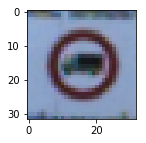

In [3]:
### Data exploration visualization code goes here.
import random
import numpy as np
import matplotlib.pyplot as plt

# Visualizations will be shown in the notebook.
%matplotlib inline
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()
plt.figure(figsize=(2,2))
plt.imshow(image)
print('Image label is : ',y_train[index])

### Distribution of classes in the training, validation and test set


Train set classes' distribution:


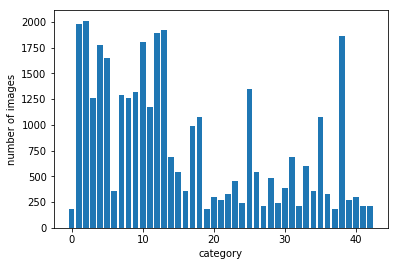

Test set classes' distribution:


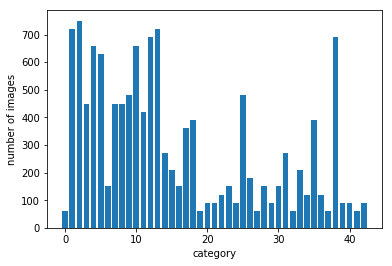

Valid set classes' distribution:


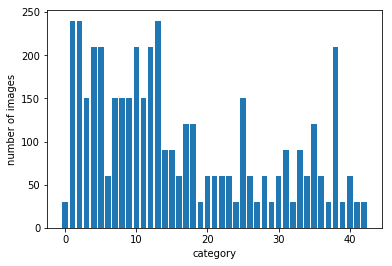

In [4]:
def count_sign(y):
    labels=np.zeros(n_classes)
    for i in range(0,len(y)):
        labels[y[i]] +=1
    return labels
    
y_train_dis= count_sign(y_train)
y_test_dis= count_sign(y_test)
y_valid_dis= count_sign(y_valid)
print("")
import matplotlib.pyplot as plt
print('Train set classes\' distribution:')
plt.xlabel('category')
plt.ylabel('number of images')
plt.bar(range(len(y_train_dis)), y_train_dis)
plt.show()

plt.xlabel('category')
plt.ylabel('number of images')
print('Test set classes\' distribution:')
plt.bar(range(len(y_test_dis)), y_test_dis)
plt.show()

plt.xlabel('category')
plt.ylabel('number of images')
print('Valid set classes\' distribution:')
plt.bar(range(len(y_valid_dis)), y_valid_dis)
plt.show()  

max_images_per_label=np.max(y_train_dis)+500

----

## Step 2: Design and Test a Model Architecture

### Preprocess data ( Augmentation, Normalize, RGB2gray )

In [5]:
import cv2
import random

##Helper functions
'''
    Data augmentation techniques:
    random rotate - -20 ~ +20 degree
    random scale - 0.5 ~ 1.5 scale
    random translate - -2 ~ +2 pixel
    random shear - -10 ~ +10 degree
    random brightness - 0.5 ~ 2.0 factor
'''

def image_rotate(img, angle):
    """Rotate the image by angle"""
    rows, cols, dims = img.shape
    matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    return cv2.warpAffine(img, matrix, (cols, rows))


def image_scale(img, scale):
    """Adjust the image size by scale"""
    rows, cols, dims = img.shape
    matrix = cv2.getRotationMatrix2D((cols/2, rows/2), 0, scale)
    return cv2.warpAffine(image, matrix, (cols, rows))


def image_translate(img, x, y):
    """Translate image by the value of x and y"""
    rows, cols, dims = img.shape
    matrix = np.float32([[1, 0, x], [0, 1, y]])
    return cv2.warpAffine(img, matrix, (cols, rows))


def image_shear(img, shear_range):
    """Shear image randomly by the factor of shear_range"""
    rows, cols, dims = img.shape
    
    pts1 = np.float32([[5, 5],[20, 5],[5, 20]])

    pt1 = 5 + shear_range * np.random.uniform() - shear_range / 2
    pt2 = 20 + shear_range * np.random.uniform() - shear_range / 2

    pts2 = np.float32([[pt1, 5], [pt2, pt1], [5, pt2]])

    matrix = cv2.getAffineTransform(pts1, pts2)
    
    return cv2.warpAffine(img, matrix, (cols, rows))


def image_brightness(image, factor):
    
    hsv = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    hsv[:,:,2] = np.minimum(hsv[:,:,2] * factor, 255)
    
    return cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)


def random_image_transform(image):
    
    randomAngle = random.uniform(-20, 20)
    output = image_rotate(image, randomAngle)
    
    randomScale = random.uniform(0.5, 1.5)
    output = image_scale(output, randomScale)
    
    randomFactor = random.uniform(0.5, 2.0)
    output = image_brightness(output, randomFactor)

    randomX = random.uniform(-2, 2)
    randomY = random.uniform(-2, 2)
    output = image_translate(output, randomX, randomY)
    
    randomShear = random.uniform(-10, 10)
    output = image_shear(output, randomShear)
    
    return output

#Center normalize
def center_normalize(img):
    
    img = img.astype('float32')
    img = (img - 128)/128
    return img

#Grayscale
def grayscale(image):
    
    imgs = np.ndarray((image.shape[0], 32, 32, 1), dtype=np.uint8)
    for i, img in enumerate(image):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.equalizeHist(img)
        img = np.expand_dims(img, axis=2)
        imgs[i] = img
    
    return imgs

def preprocess(img):
    
    img = grayscale(img)
    img = center_normalize(img)
    return img

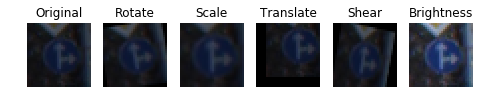

In [6]:
# Show how data augmentation look like 
image = X_train[1000, :, :, :]

transform_exmpl = [image,
                   image_rotate(image, 10),
                   image_scale(image, 1.2),
                   image_translate(image, 5, -5),
                   image_shear(image, 10),
                   image_brightness(image, 2.0)]

transform_title = ['Original', 'Rotate', 'Scale', 'Translate', 'Shear', 'Brightness']

fig, sign = plt.subplots(1, 6, figsize=(8,5))
for i in range(6):
    sign[i].imshow(transform_exmpl[i])
    sign[i].axis('off')
    sign[i].set_title(transform_title[i])

In [7]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.

import numpy as np

#Generate fake data
new_train=[]
new_label=[]

while np.sum(y_train_dis) < n_classes * max_images_per_label:
    for index, image in enumerate(X_train):
        img_class = y_train[index]
        
        if y_train_dis[img_class] < max_images_per_label:
            
            new_train.append(random_image_transform(image))
            new_label.append(img_class)
            y_train_dis[img_class] += 1

X_train_n = np.append(X_train, new_train, axis=0)
y_train_n = np.append(y_train, new_label, axis=0)

X_train = X_train_n
y_train = y_train_n

# Preprocess the data
X_train_preprocess = preprocess(X_train)
X_valid_preprocess = preprocess(X_valid)
X_test_preprocess = preprocess(X_test)

print("Number of preprocessed training data =", X_train_preprocess.shape[0])
print("Number of preprocessed validation data =", X_valid_preprocess.shape[0])
print("Number of testing data =", X_test_preprocess.shape[0])
print("Train data shape =", X_train_preprocess.shape[1:4])
print()


X_train = X_train_preprocess
X_valid = X_valid_preprocess
X_test = X_test_preprocess

Number of preprocessed training data = 107930
Number of preprocessed validation data = 4410
Number of testing data = 12630
Train data shape = (32, 32, 1)



### Setup TensorFlow

In [8]:
import tensorflow as tf

EPOCHS = 100
BATCH_SIZE = 128
KEEP_PROB= 0.5

### Model Architecture

In [9]:
from tensorflow.contrib.layers import flatten


def TSCNet(x,keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    #Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    #Activation.
    conv1 = tf.nn.relu(conv1)

    #Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    #Activation.
    conv2 = tf.nn.relu(conv2)
    #conv2    = tf.nn.dropout(conv2, keep_prob)
    
    #Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    #Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    #Activation.
    fc1    = tf.nn.relu(fc1)
    #dropout
    #fc1    = tf.nn.dropout(fc1, keep_prob)
    
    #Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    #Activation.
    fc2    = tf.nn.relu(fc2)
    #dropout
    fc2    = tf.nn.dropout(fc2, keep_prob)
    
    #Layer 5: Fully Connected. Input = 84. Output = n_classes.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    l2_loss = tf.nn.l2_loss(conv1_W) + tf.nn.l2_loss(conv1_b) + tf.nn.l2_loss(conv2_W) + tf.nn.l2_loss(conv2_b)+tf.nn.l2_loss(fc1_W) + tf.nn.l2_loss(fc1_b)+tf.nn.l2_loss(fc2_W) + tf.nn.l2_loss(fc2_b)+tf.nn.l2_loss(fc3_W) + tf.nn.l2_loss(fc3_b)
    return logits,l2_loss

### Train, Validate and Test the Model

In [10]:
#Placeholders
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)

### Train Pipeline

In [11]:
rate = 0.001

logits,l2loss = TSCNet(x,keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

##L2 Regularation preventing overfitting 

beta = 0.001
loss_operation = tf.reduce_mean(cross_entropy)+beta*l2loss
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

### Model Evaluation

In [12]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        #loss = sess.run(loss_operation, feed_dict={x: batch_x, y: batch_y})
        #print("Evaluate Loss = {:.3f}".format(loss))
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train the Model

In [13]:
from sklearn.utils import shuffle

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:KEEP_PROB})
            #loss = sess.run(loss_operation, feed_dict={x: batch_x, y: batch_y,keep_prob:1.0})
            #print("Train Loss = {:.3f}".format(loss))
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './tscnet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.809

EPOCH 2 ...
Validation Accuracy = 0.879

EPOCH 3 ...
Validation Accuracy = 0.911

EPOCH 4 ...
Validation Accuracy = 0.925

EPOCH 5 ...
Validation Accuracy = 0.937

EPOCH 6 ...
Validation Accuracy = 0.951

EPOCH 7 ...
Validation Accuracy = 0.950

EPOCH 8 ...
Validation Accuracy = 0.960

EPOCH 9 ...
Validation Accuracy = 0.945

EPOCH 10 ...
Validation Accuracy = 0.950

EPOCH 11 ...
Validation Accuracy = 0.961

EPOCH 12 ...
Validation Accuracy = 0.953

EPOCH 13 ...
Validation Accuracy = 0.967

EPOCH 14 ...
Validation Accuracy = 0.960

EPOCH 15 ...
Validation Accuracy = 0.958

EPOCH 16 ...
Validation Accuracy = 0.960

EPOCH 17 ...
Validation Accuracy = 0.967

EPOCH 18 ...
Validation Accuracy = 0.964

EPOCH 19 ...
Validation Accuracy = 0.960

EPOCH 20 ...
Validation Accuracy = 0.970

EPOCH 21 ...
Validation Accuracy = 0.973

EPOCH 22 ...
Validation Accuracy = 0.972

EPOCH 23 ...
Validation Accuracy = 0.968

EPOCH 24 ...
Validation Accura

### Evaluate the Model

In [14]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from .\tscnet
Test Accuracy = 0.936


## Step 3: Test a Model on New Images


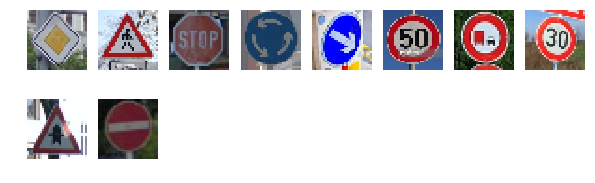

In [15]:
import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
%matplotlib inline

import tensorflow as tf

from pandas.io.parsers import read_csv

ImagePath = './test/*.png'
test_images = []

for index, img in enumerate(glob.glob(ImagePath)):
    image = cv2.imread(img)
    image = cv2.resize(image, (32, 32))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    test_images.append(image)

# Show original test images
figure = plt.figure()
figure.set_figwidth(10)
figure.set_figheight(3)

for index, image in enumerate(test_images):
    t = figure.add_subplot(2, 8, index + 1)
    t.axis('off')
    t.imshow(image)

### Load and Output the Images

In [ ]:
### Load the images and plot them here.

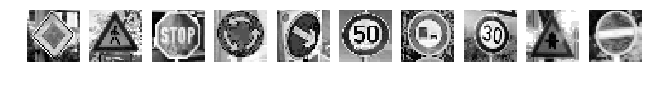

In [16]:
X_test_new = np.array(test_images)
X_test_new = preprocess(X_test_new)

# Show preprocessed test images
figure = plt.figure()
figure.set_figwidth(11)
figure.set_figheight(4)

for index, image in enumerate(X_test_new):
    t = figure.add_subplot(2, 10, index + 1)
    t.axis('off')
    image = X_test_new[index].squeeze()
    t.imshow(image, cmap='gray')

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.

In [17]:
signnames = read_csv("signnames.csv").values[:, 1]
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('./tscnet.meta')
    saver.restore(sess, save_path='./tscnet')
    
    # Calculate the top 5
    softmax_logits = tf.nn.softmax(logits)
    top_5 = tf.nn.top_k(softmax_logits, k=5)
    top_5_pred = sess.run(top_5, feed_dict={x: X_test_new, keep_prob: 1.0})
    
    predict_values = top_5_pred.values
    predict_indices = top_5_pred.indices
    
    for i, image in enumerate(X_test_new):
        predict = predict_values[i][0]
        signname = signnames[predict_indices[i][0].astype(int)]
        # print the sign name and its probability
        print('{} ({:.2f}%)'.format(signname, 100*predict))

INFO:tensorflow:Restoring parameters from ./tscnet
Priority road (100.00%)
Pedestrians (89.93%)
Stop (99.82%)
Speed limit (50km/h) (31.02%)
Keep right (100.00%)
Speed limit (50km/h) (68.56%)
No passing for vehicles over 3.5 metric tons (99.98%)
Speed limit (80km/h) (99.71%)
Right-of-way at the next intersection (99.81%)
No entry (99.95%)


### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

In [18]:
new_img_predict_accuracy = 8/10
print('Prediction accuracy on new images: ', new_img_predict_accuracy*100, '%')

Prediction accuracy on new images:  80.0 %


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
# Top 5 softmax possibilities have been calculated above, now the output is visualized here.
for i, image in enumerate(X_test_new):
    print('Image', i+1)
    
    for num in range(0, 5):
        predict = values[i][num]
        signname = signnames[indices[i][num].astype(int)]
        # print the sign name and its probability
        print('{} ({:.2f}%)'.format(signname, 100*predict))
      
    print()